# Introduction
This notebook will show how to perform feature engineering to extract important signals from raw customer events SageMaker PySpark library.

We will manipulate data through Spark using a SparkSession, on an EMR cluster provisioned within SageMaker Studio. We'll leverage one of the SparkMagic kernels available within SageMaker Studio to commnicate with the given EMR cluster for distributed processing. Then, we will persist the final training dataset to S3 for training and inference purposes. 

You can visit SageMaker Spark’s GitHub repository at https://github.com/aws/sagemaker-spark to learn more about SageMaker Spark.

This notebook was created and tested on an ml.m5.large notebook instance.

# Data

We'll use the dataset provided by KKBox, a music streaming service made publically available by Kaggle [here](https://www.kaggle.com/competitions/kkbox-churn-prediction-challenge/data). The goal for the challenge is to predict whether a user will churn after his/her subscription expires. Specifically, we want to forecast if a user make a new service subscription transaction within 30 days after the current membership expiration date.

# Connect to an Existing EMR Cluster

We are going to connect the EMR cluster using the SageMaker Studio Analytics Extension before running any spark commands. 

## SageMaker Studio Analytics Extension
This is a notebook extension provided by AWS SageMaker Studio Team to integrate with analytics resources. Currently, it supports connecting SageMaker Studio Notebook to Spark(EMR) cluster through SparkMagic library.

## Usage
Before you can use the magic command to connect Studio notebook to EMR, please ensure the SageMaker Studio has the connectivity to Spark cluster(livy service). You can refer to this [AWS blog](https://aws.amazon.com/blogs/machine-learning/part-1-create-and-manage-amazon-emr-clusters-from-sagemaker-studio-to-run-interactive-spark-and-ml-workloads/) for how to set up SageMaker Studio and EMR cluster.

In [2]:
%load_ext sagemaker_studio_analytics_extension.magics
%sm_analytics emr connect --cluster-id j-1W8LX4JV7AGOM --auth-type None   

Successfully read emr cluster(j-1W8LX4JV7AGOM) details
Initiating EMR connection..
Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
3,application_1675012510829_0004,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.
{"namespace": "sagemaker-analytics", "cluster_id": "j-1W8LX4JV7AGOM", "error_message": null, "success": true, "service": "emr", "operation": "connect"}


# Setup

First, we import the necessary modules and create the SparkSession, then update the Spark configuration for the given application context.

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, BooleanType, DateType, StringType
from pyspark.sql.functions import col, sum, avg, count
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql.functions import to_date
from pyspark.sql.functions import quarter
from pyspark.sql.functions import log
from pyspark.sql.functions import mean
from pyspark.sql.functions import when
from pyspark.sql.functions import datediff
from pyspark.sql.functions import lit
import dateutil.parser
from pyspark.sql.functions import log1p

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
spark = SparkSession.builder.config("mapreduce.fileoutputcommitter.marksuccessfuljobs", "false").\
        config("spark.driver.maxResultSize", "30g").\
        getOrCreate()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
transactions_dataset_s3 = "s3://sagemaker-us-east-1-602900100639/data/kkbox-customer-churn-model/raw/transactions.csv"
churn_dataset_s3 = "s3://sagemaker-us-east-1-602900100639/data/kkbox-customer-churn-model/raw/train.csv"
members_dataset_s3 = "s3://sagemaker-us-east-1-602900100639/data/kkbox-customer-churn-model/raw/members_v3.csv"
users_log_dataset_s3 = "s3://sagemaker-us-east-1-602900100639/data/kkbox-customer-churn-model/raw/user_logs.csv"
processed_train_dataset_s3 = "s3://sagemaker-us-east-1-602900100639/data/kkbox-customer-churn-model/processed/train"
processed_test_dataset_s3 = "s3://sagemaker-us-east-1-602900100639/data/kkbox-customer-churn-model/processed/test"
processed_val_dataset_s3 = "s3://sagemaker-us-east-1-602900100639/data/kkbox-customer-churn-model/processed/validation"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Dataset

The provided dataset contains information about whether the subscribers are churn or not as of March 2017.

* Transaction data for the subscribers through 2017.
* Membership data for all the subscribers in the transaction data.
* User log data for subscriber interaction with the music streaming application.


## Churn Dataset 
Containing the user ids and whether they have churned.

* msno: user id
* is_churn: This is the target variable. Churn is defined as whether the user did not continue the subscription within 30 days of expiration. is_churn = 1 means churn,is_churn = 0 means renewal.


In [6]:
train_df = spark.read.format('csv').options(header='true', inferSchema='true').load(churn_dataset_s3).cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
train_df.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------+
|                msno|is_churn|
+--------------------+--------+
|waLDQMmcOu2jLDaV1...|       1|
|QA7uiXy8vIbUSPOkC...|       1|
|fGwBva6hikQmTJzrb...|       1|
|mT5V8rEpa+8wuqi6x...|       1|
|XaPhtGLk/5UvvOYHc...|       1|
|GBy8qSz16X5iYWD+3...|       1|
|lYLh7TdkWpIoQs3i3...|       1|
|T0FF6lumjKcqEO0O+...|       1|
|Nb1ZGEmagQeba5E+n...|       1|
|MkuWz0Nq6/Oq5fKqR...|       1|
|I8dFN2EjFN1mt4Xel...|       1|
|0Ip2rzeoa44alqEw3...|       1|
|piVhWxrWDmiNQFY6x...|       1|
|wEUOkYvyz3xTOx2p9...|       1|
|xt4EjWRyXBMgEgKBJ...|       1|
|QS3ob4zLlWcWzBIlb...|       1|
|9iW/UpqRoviya9CQh...|       1|
|d7QVMhAzjj4yc1Ojj...|       1|
|uV7rJjHPrpNssDMmY...|       1|
|TZxhkfZ9NwxqnUrNs...|       1|
+--------------------+--------+
only showing top 20 rows

In [8]:
import matplotlib.pyplot as plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
%matplotlib inline

In [10]:
train_pd = train_df.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
train_pd['is_churn'].value_counts().plot.bar(x='is_churn', title="customer churn distribution")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<AxesSubplot:title={'center':'customer churn distribution'}>

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

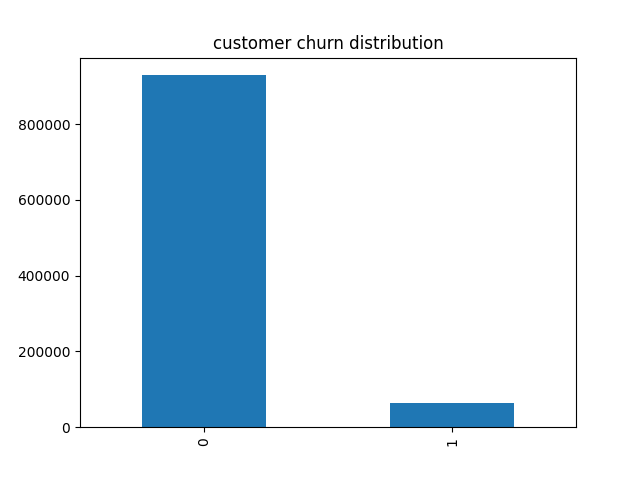

In [12]:
%matplot plt

## Transactions DataSet
transactions of users through 2017.

* msno: user id
* payment_method_id: payment method
* payment_plan_days: length of membership plan in days
* plan_list_price: in New Taiwan Dollar (NTD)
* actual_amount_paid: in New Taiwan Dollar (NTD)
* is_auto_renew
* transaction_date: format %Y%m%d
* membership_expire_date: format %Y%m%d
* is_cancel: whether or not the user canceled the membership in this transaction.

In [13]:
trans_df = spark.read.format('csv').options(header='true', inferSchema='true').load(transactions_dataset_s3).cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
trans_df = trans_df.withColumn("transaction_date",col("transaction_date").cast(StringType())).withColumn("membership_expire_date",col("membership_expire_date").cast(StringType()))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
def find_mode(x):
  """Find the value with highest occurence in the list"""
  return max(set(x), key=x.count)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
find_mode_udf = F.udf(find_mode, T.IntegerType())
payment_plan_days_df = trans_df.groupby("msno").agg(find_mode_udf(F.collect_list('payment_plan_days')).alias("max_plan_days")).cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
payment_plan_days_pd = payment_plan_days_df.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
plt.cla()
payment_plan_days_pd['max_plan_days'].value_counts().sort_index().plot.bar(x="max_plan_days",  title="Maximum Plan Days Distribution", figsize=(20, 10))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<AxesSubplot:title={'center':'Maximum Plan Days Distribution'}>

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

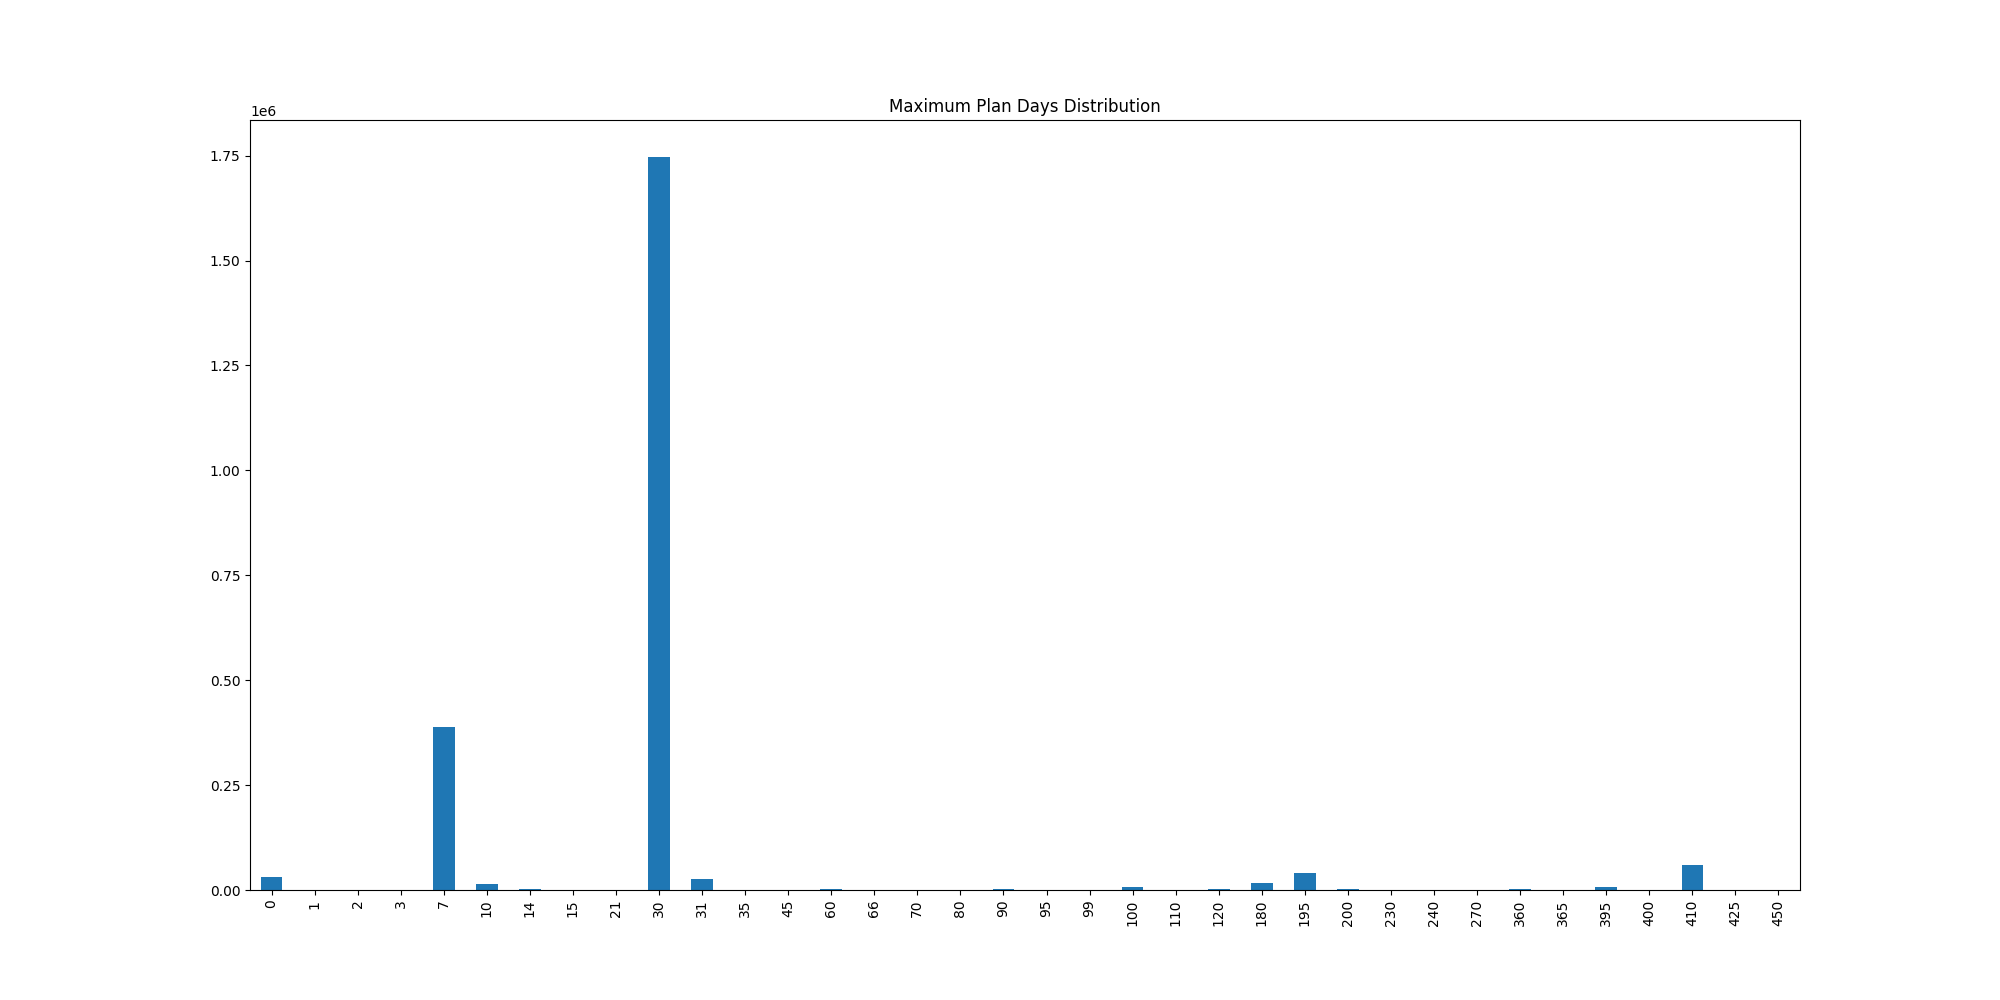

In [19]:
%matplot plt

The plot above shows most active subscription plans are monthly, followed by weekly. Weekly users are mostly attributed to the trial subscription.

In [20]:
payment_method_id_df = trans_df.groupby("msno").agg(find_mode_udf(F.collect_list('payment_method_id')).alias("max_payment_method_id")).cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
payment_method_id_pd = payment_method_id_df.toPandas()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
plt.cla()
payment_method_id_pd['max_payment_method_id'].value_counts().sort_index().plot.bar(x="max_payment_method_id",  title="Payment Method Distribution", figsize=(20, 10))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<AxesSubplot:title={'center':'Payment Method Distribution'}>

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

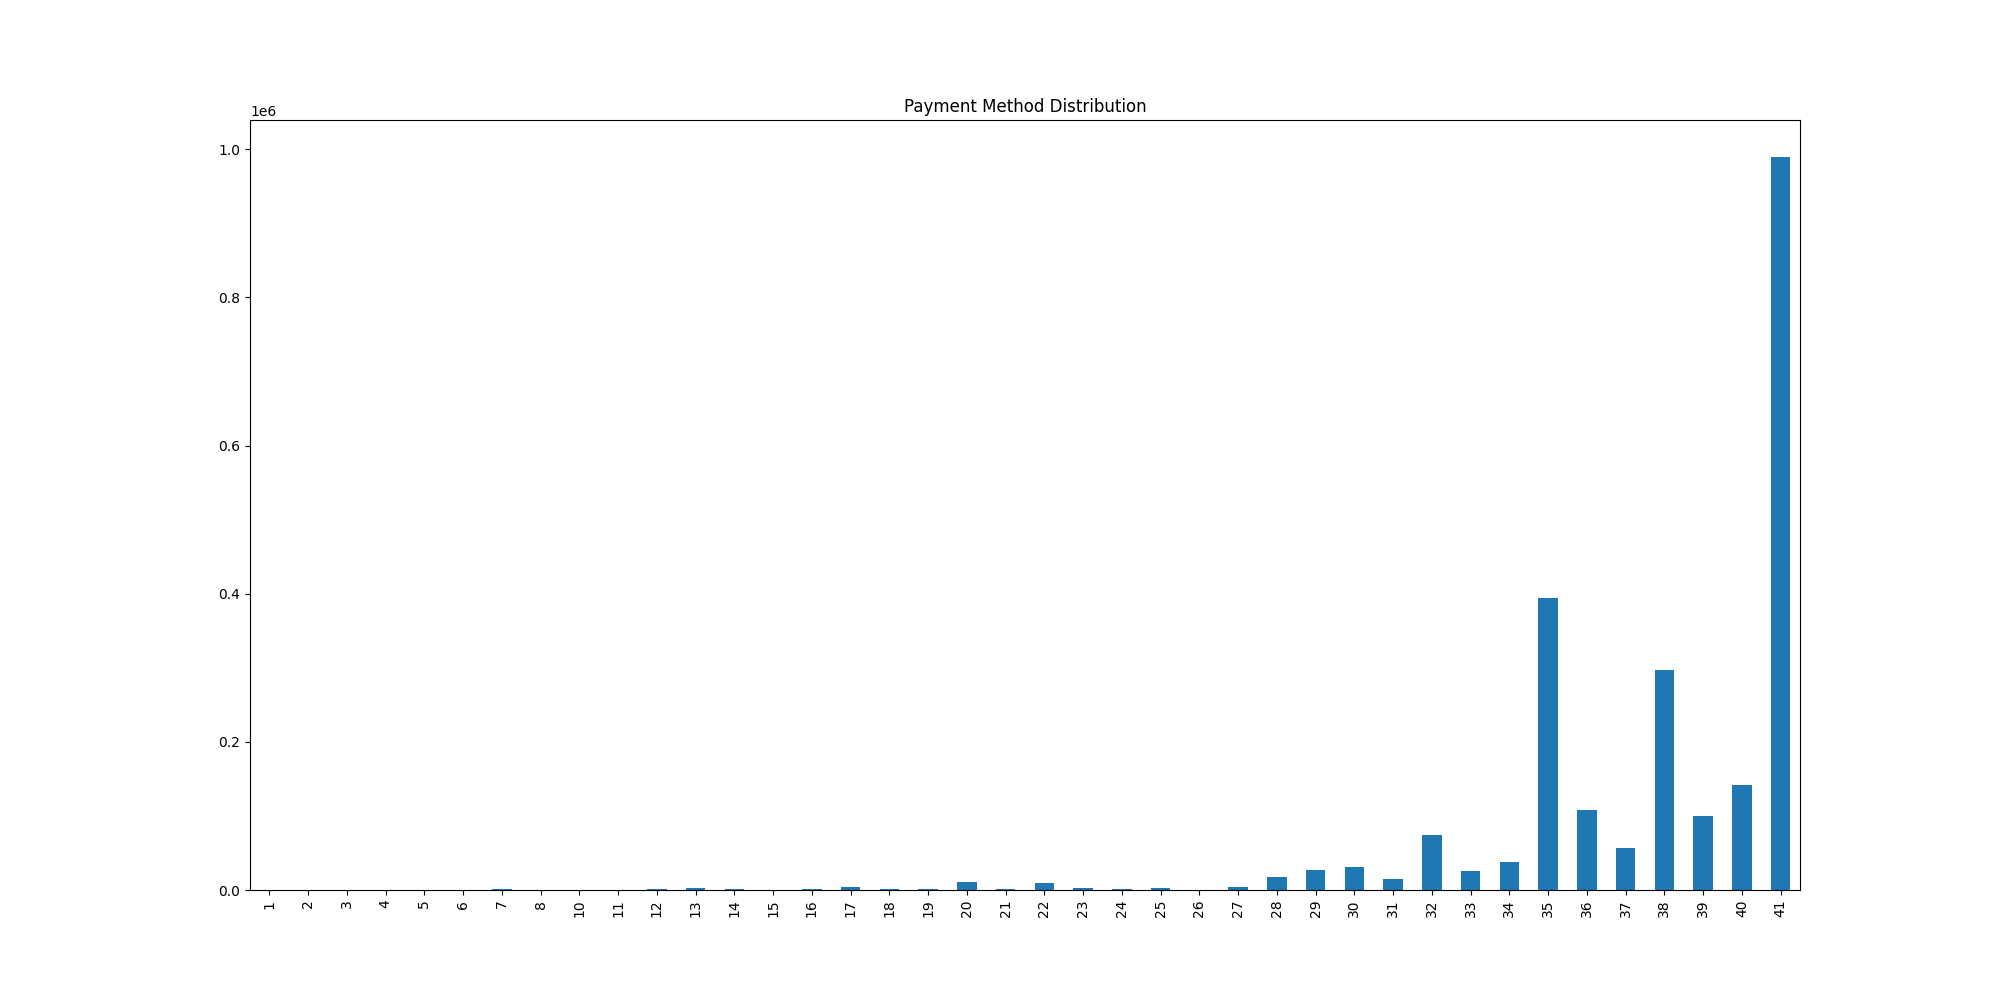

In [23]:
%matplot plt

In [24]:
revenue = trans_df.groupby("msno").agg(sum("actual_amount_paid").alias("total_amount_paid")).cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
revenue_pd = revenue.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
import pandas as pd

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
payment_plan_days_revenue_pd = pd.merge(payment_plan_days_pd, revenue_pd, on="msno", how="inner")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
plt.cla()
payment_plan_days_revenue_pd.plot.scatter(x="max_plan_days", y="total_amount_paid", title="Relationships between plan days and revenue")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<AxesSubplot:title={'center':'Relationships between plan days and revenue'}, xlabel='max_plan_days', ylabel='total_amount_paid'>

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

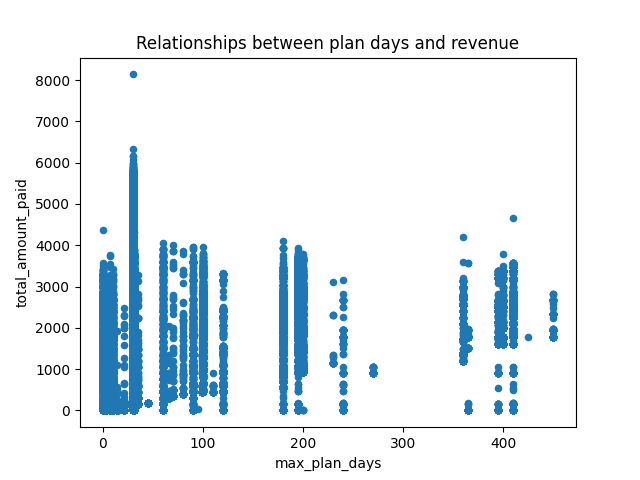

In [29]:
%matplot plt

The plot above reveals an interesting observation that the highest revenue do not come from users who subscribe to longest period. 

In [30]:
auto_renew_df = trans_df.groupby("msno").agg(find_mode_udf(F.collect_list('is_auto_renew')).alias("max_auto_renew")).cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
is_canceled_df = trans_df.groupby("msno").agg(sum("is_cancel").alias("total_is_canceled"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
cust_payment_method_df = trans_df.groupby("msno").agg(count("payment_method_id").alias("payment_method_id"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
trans_df = trans_df.withColumn("quarter",quarter(to_date(col("transaction_date"), "yyyyMMdd"))). \
        withColumn("quarter_end",quarter(to_date(col("membership_expire_date"), "yyyyMMdd")))


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
quarter_df = trans_df.groupby("msno").agg(find_mode_udf(F.collect_list('quarter')).alias("max_quarter"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
merged_df = cust_payment_method_df.join(payment_method_id_df, on="msno").join(payment_plan_days_df, on="msno").join(revenue, on="msno").join(auto_renew_df, on="msno").join(is_canceled_df, on="msno").join(quarter_df, on="msno")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
merged_df = merged_df.withColumnRenamed("payment_method_id", "regist_trans")\
       .withColumnRenamed("max_payment_method_id", "mst_frq_pay_met")\
       .withColumnRenamed("max_plan_days", "mst_frq_plan_days")\
       .withColumnRenamed("total_amount_paid", "revenue")\
       .withColumnRenamed("max_auto_renew", "is_auto_renew")\
       .withColumnRenamed("total_is_canceled", "regist_cancels")\
       .withColumnRenamed("max_quarter", "qtr_trans").cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
merged_pd = merged_df.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
merged_pd.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Index(['msno', 'regist_trans', 'mst_frq_pay_met', 'mst_frq_plan_days',
       'revenue', 'is_auto_renew', 'regist_cancels', 'qtr_trans'],
      dtype='object')

In [39]:
plt.cla()
merged_pd['qtr_trans'].value_counts().sort_index().plot.bar(x='qtr_trans', title="Registration By Quarter Distribution", figsize=(20, 10))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<AxesSubplot:title={'center':'Registration By Quarter Distribution'}>

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

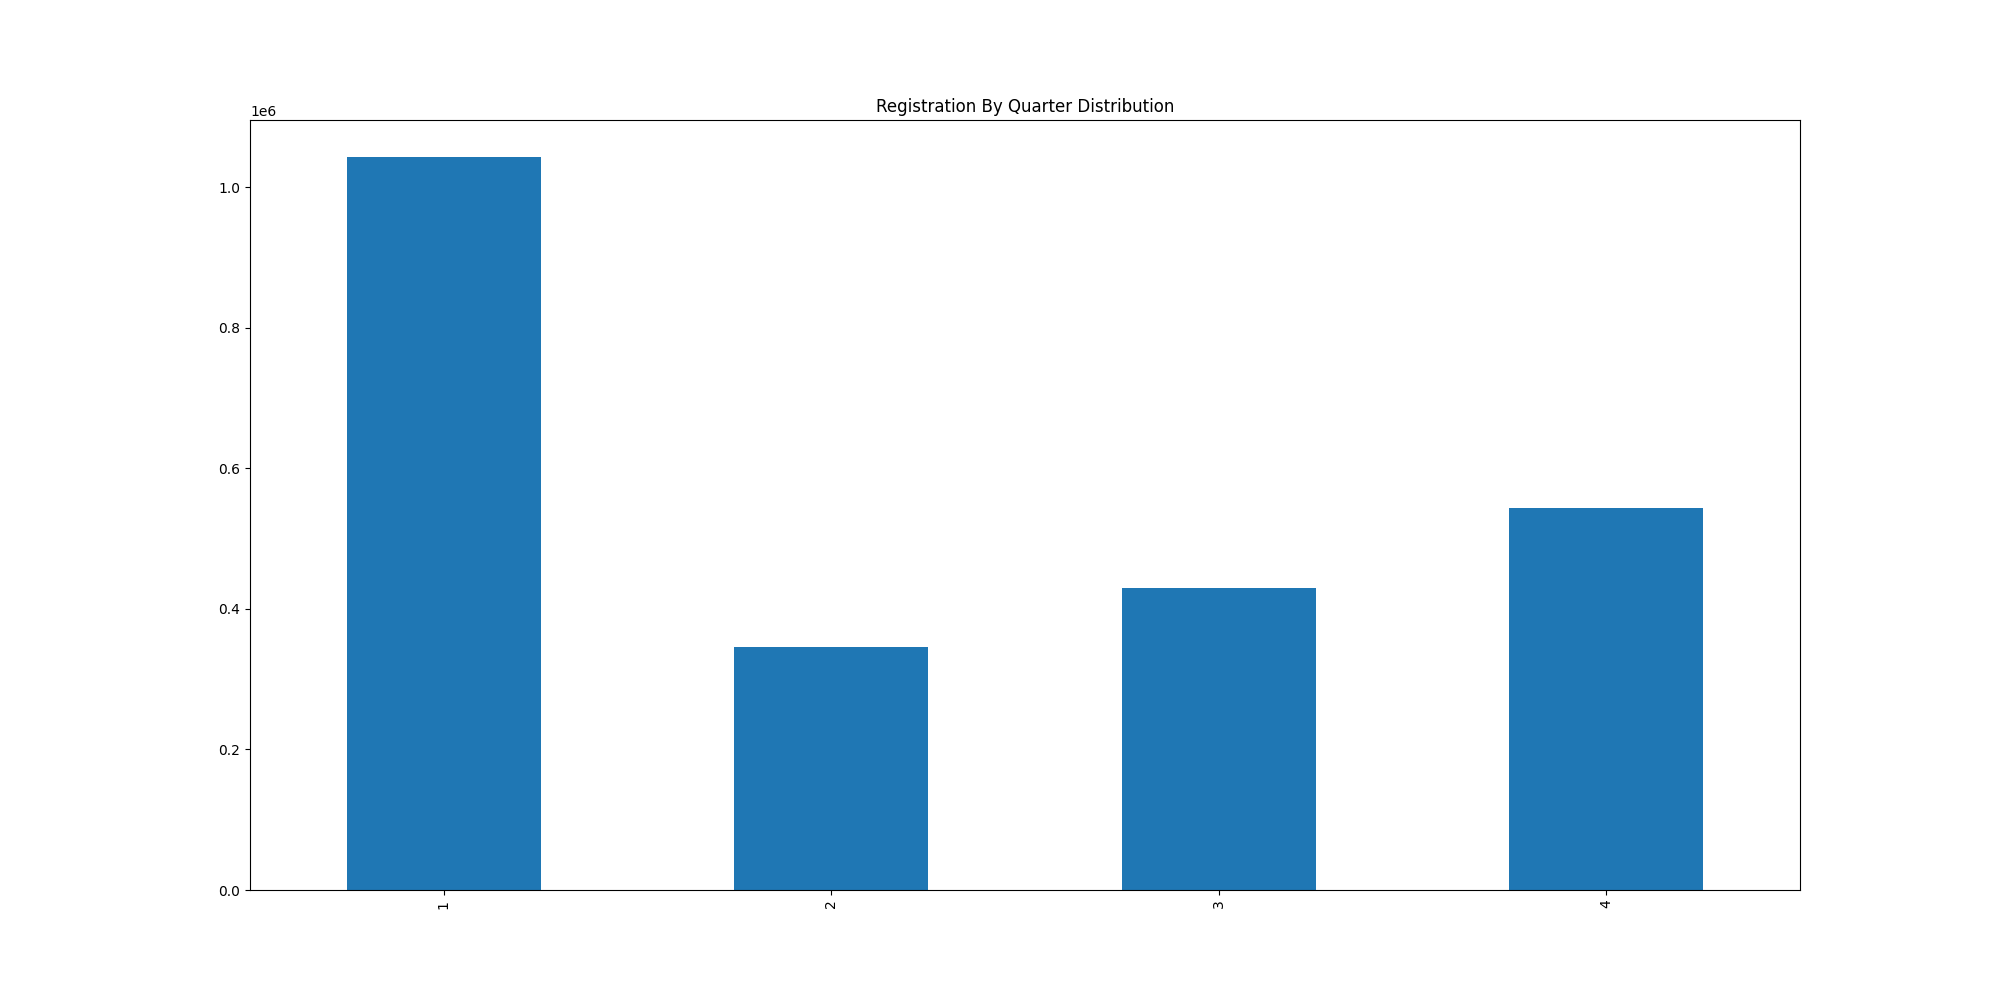

In [40]:
%matplot plt

The plot above shows the most active registration falls on the first and forth quarters.

In [41]:
members_df = spark.read.format('csv').options(header='true', inferSchema='true').load(members_dataset_s3)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [42]:
members_df = members_df.na.fill("other").cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
logs_df = spark.read.format('csv').options(header='true', inferSchema='true').load(users_log_dataset_s3)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
logs_df = logs_df.withColumn("total_secs",log(logs_df.total_secs))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [45]:
logs_mean_df = logs_df.groupby("msno").agg(mean("num_25").alias("num_25"), mean("num_50").alias("num_50"), mean("num_75").alias("num_75"), mean("num_985").alias("num_985"), mean("num_100").alias("num_100"), mean("num_unq").alias("num_unq"), mean("total_secs").alias("total_secs")).cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [46]:
all_df = train_df.join(merged_df, on="msno", how="left").join(members_df, on="msno", how="left").join(logs_mean_df, on="msno", how="left").cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [47]:
all_pd = all_df.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [48]:
age_groups_pd = pd.cut(all_pd.bd,bins=[10,18,35,55,99],labels=["Teenagers","Young Adult","Middle Age Adult", "Elderly"])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [49]:
plt.cla()
age_groups_pd.value_counts().plot.bar(title="Age Group Distribution")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<AxesSubplot:title={'center':'Age Group Distribution'}>

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

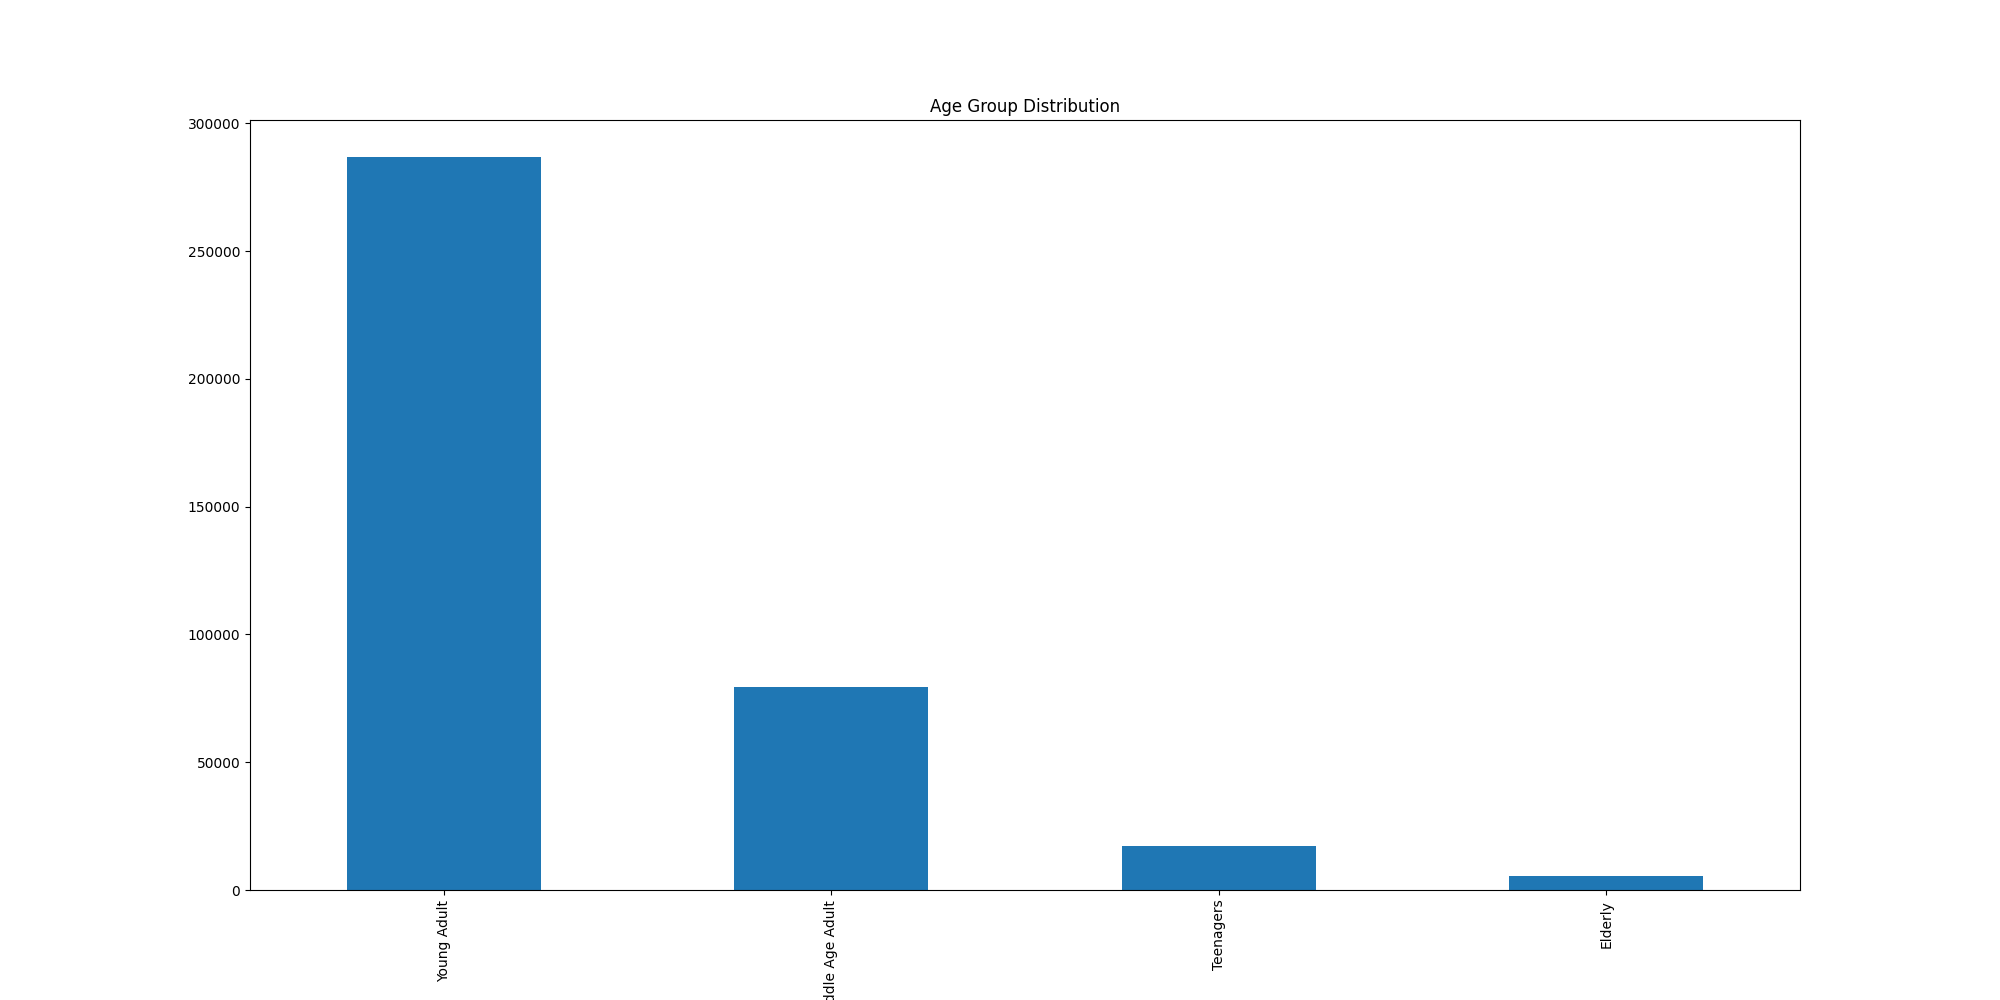

In [50]:
%matplot plt

The plot above reveals that Young Adults (18-35) are the most popular age group who subscribe to the service.
Based on the obervation, we will remove the outliers (elderly) from the dataset.

In [51]:
upper_thresh = 80
all_df = all_df.withColumn("bd", when(all_df.bd > upper_thresh, 0))
all_df = all_df.na.fill(value=0,subset=["bd"])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [52]:
end_dt = dateutil.parser.parse('2017-03-31') 
all_df = all_df.withColumn("tenure",datediff(to_date(lit(end_dt), "yyyy-MM-dd"), to_date(all_df.registration_init_time.cast(StringType()), "yyyyMMdd")) / 365).cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [53]:
all_pd = all_df.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [54]:
plt.cla()
all_pd.plot.scatter(x="tenure", y="revenue", title="Relationships between tenure and revenue", figsize=(20,10))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<AxesSubplot:title={'center':'Relationships between tenure and revenue'}, xlabel='tenure', ylabel='revenue'>

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

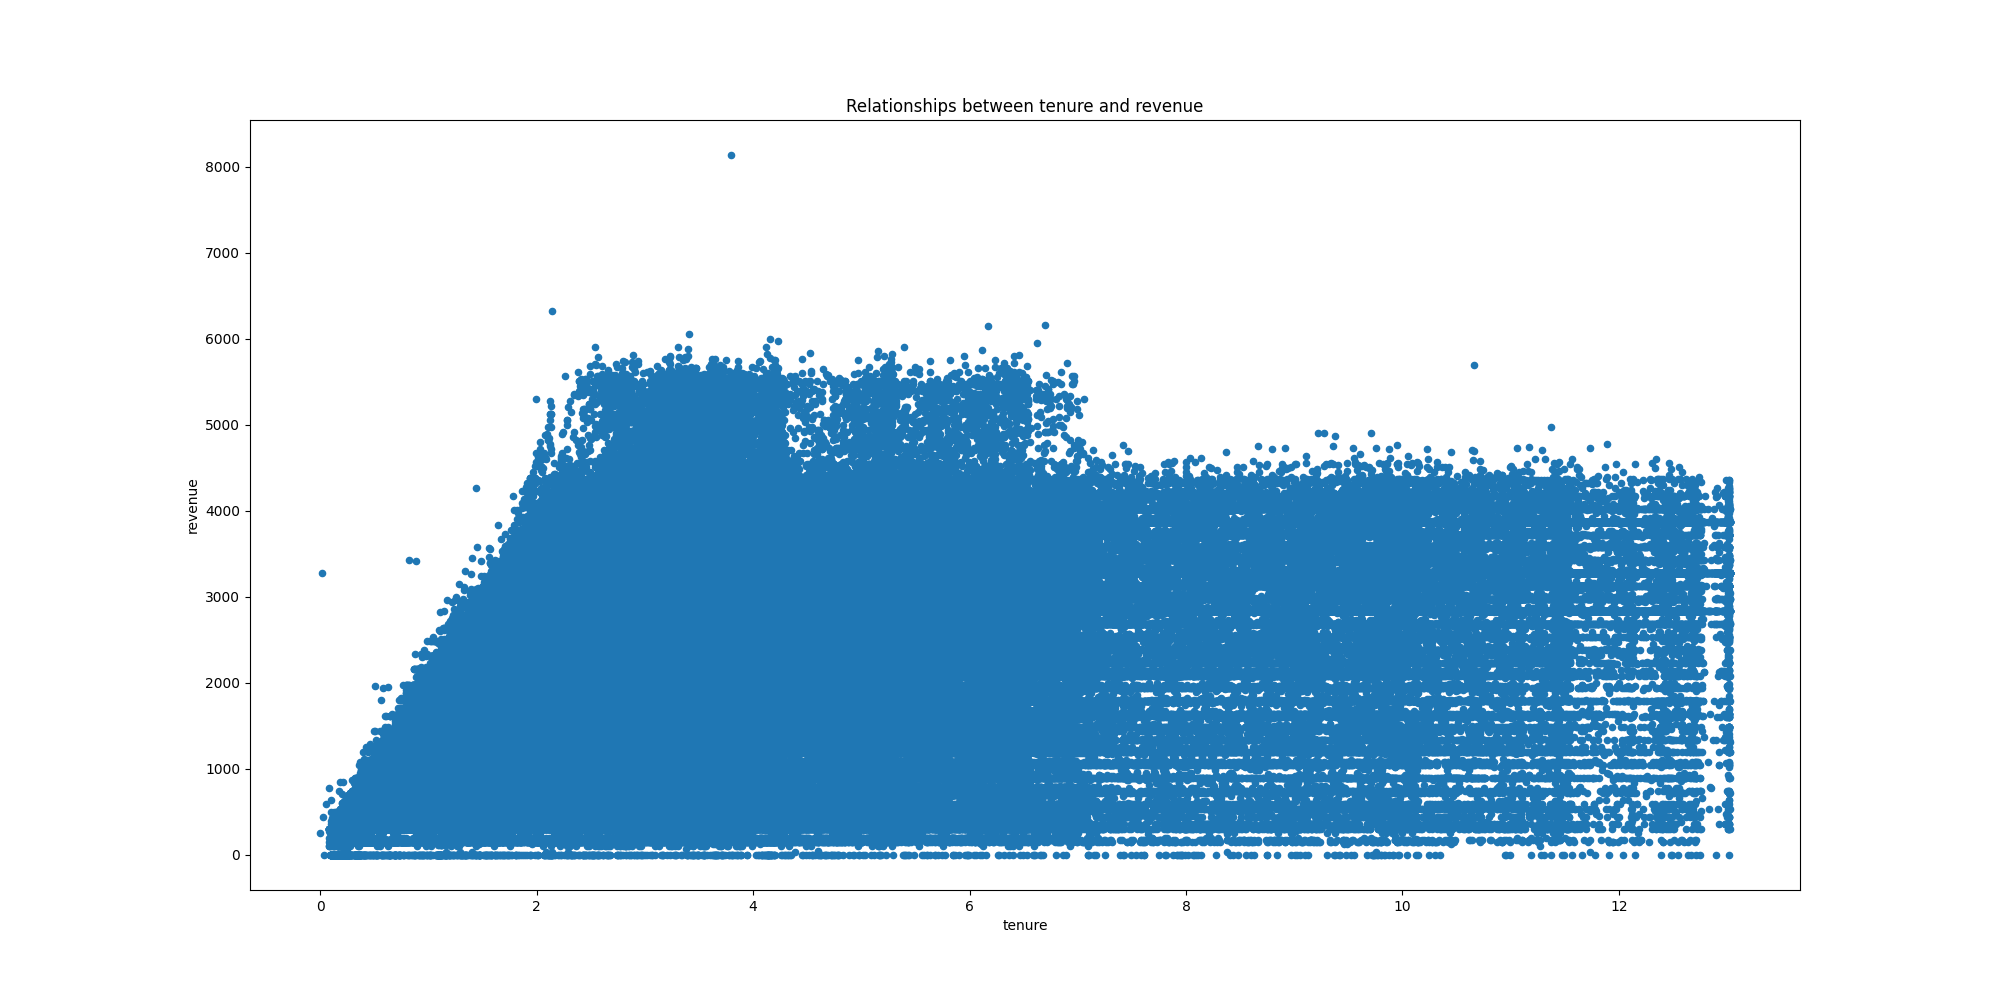

In [55]:
%matplot plt

We are going to clean up the dataset by assign a category (other) for the bottom .5 percent of the users, or null values for the following features

* registered_via
* mst_frq_pay_met
* city

In [56]:
all_df_cnt = all_df.count()
filtered_cols_registered_via = all_df.groupBy('registered_via').agg(count("registered_via").alias("count_registered_via")).filter(col("count_registered_via") / all_df_cnt < 0.005).select("registered_via").rdd.map(lambda x : x[0]).collect()
filtered_df = all_df.withColumn("registered_via", when(all_df.registered_via.isin(filtered_cols_registered_via) ,"other").\
                                when(all_df.registered_via.isNull() ,"other").otherwise(all_df.registered_via))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [57]:
filtered_cols_mst_frq_pay_met = filtered_df.groupBy('mst_frq_pay_met').agg(count("mst_frq_pay_met").alias("count_mst_frq_pay_met")).filter(col("count_mst_frq_pay_met") / all_df_cnt < 0.005).select("mst_frq_pay_met").rdd.map(lambda x : x[0]).collect()
filtered_df = filtered_df.withColumn("mst_frq_pay_met", when(filtered_df.mst_frq_pay_met.isin(filtered_cols_mst_frq_pay_met) ,"other").\
                                     when(filtered_df.mst_frq_pay_met.isNull() ,"other").otherwise(filtered_df.mst_frq_pay_met))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [58]:
filtered_cols_city = filtered_df.groupBy('city').agg(count("city").alias("count_city")).filter(col("count_city") / all_df_cnt < 0.005).select("city").rdd.map(lambda x : x[0]).collect()
filtered_df = filtered_df.withColumn("city", when(filtered_df.city.isin(filtered_cols_city) ,"other").\
                                     when(filtered_df.city.isNull() ,"other").otherwise(filtered_df.city))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

We will apply log1p to normalize the given columns

In [59]:
filtered_df = filtered_df.withColumn("regist_trans", log1p("regist_trans")).\
withColumn("mst_frq_plan_days", log1p("mst_frq_plan_days")).\
withColumn("revenue", log1p("revenue")).\
withColumn("regist_cancels", log1p("regist_cancels"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Apply Train, Test And Validation Split

In [60]:
train, test, validation = filtered_df.randomSplit(weights=[0.7,0.2, 0.1], seed=200)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Drop the columns that are not considered as an important signal for our model

In [61]:
final_train = train.drop('registration_init_time')
final_test = test.drop('registration_init_time')
final_val = validation.drop('registration_init_time')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Many numeric fields contain missing values, so we'll need to apply mean imputation to fill in those null values. 
For that, we'll use pyspark ML feature Imputer to help us fit and transform the columns

In [62]:
from pyspark.ml.feature import Imputer

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [63]:
imputer = Imputer()
imputer.setInputCols(['num_25','num_50','num_75','num_985','num_100','num_unq','total_secs', 'tenure'])
imputer.setOutputCols(['num_25_o','num_50_o','num_75_o','num_985_o','num_100_o','num_unq_o','total_secs_o', 'tenure_o'])
model = imputer.fit(final_train)
model.setInputCols(['num_25','num_50','num_75','num_985','num_100','num_unq','total_secs', 'tenure'])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

ImputerModel: uid=Imputer_5780832c02f0, strategy=mean, missingValue=NaN, numInputCols=8, numOutputCols=8

In [64]:
imputed_train = model.transform(final_train).cache()
imputed_test = model.transform(final_test).cache()
imputed_val = model.transform(final_val).cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Restore the column names after imputation.

In [65]:
temp_imputed_train = imputed_train.drop('num_25','num_50','num_75','num_985','num_100','num_unq','total_secs', 'tenure')
temp_imputed_test = imputed_test.drop('num_25','num_50','num_75','num_985','num_100','num_unq','total_secs', 'tenure')
temp_imputed_val = imputed_val.drop('num_25','num_50','num_75','num_985','num_100','num_unq','total_secs', 'tenure')

temp_imputed_train = temp_imputed_train.withColumnRenamed("num_25_o","num_25")\
.withColumnRenamed("num_50_o","num_50")\
.withColumnRenamed("num_75_o","num_75")\
.withColumnRenamed("num_985_o","num_985")\
.withColumnRenamed("num_100_o","num_100")\
.withColumnRenamed("num_unq_o","num_unq")\
.withColumnRenamed("total_secs_o","total_secs")\
.withColumnRenamed("tenure_o","tenure")

temp_imputed_test = temp_imputed_test.withColumnRenamed("num_25_o","num_25")\
.withColumnRenamed("num_50_o","num_50")\
.withColumnRenamed("num_75_o","num_75")\
.withColumnRenamed("num_985_o","num_985")\
.withColumnRenamed("num_100_o","num_100")\
.withColumnRenamed("num_unq_o","num_unq")\
.withColumnRenamed("total_secs_o","total_secs")\
.withColumnRenamed("tenure_o","tenure")

temp_imputed_val = temp_imputed_val.withColumnRenamed("num_25_o","num_25")\
.withColumnRenamed("num_50_o","num_50")\
.withColumnRenamed("num_75_o","num_75")\
.withColumnRenamed("num_985_o","num_985")\
.withColumnRenamed("num_100_o","num_100")\
.withColumnRenamed("num_unq_o","num_unq")\
.withColumnRenamed("total_secs_o","total_secs")\
.withColumnRenamed("tenure_o","tenure")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Next, we need to apply encoding for the categorical columns. We'll use pyspark ML StringIndexer to apply appropriate index for each column category as followed:

* city
* gender
* registered Via
* wtr_trans
* mst_frq_pay_met
* is_auto_renew

In [66]:
from pyspark.ml.feature import StringIndexer

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [67]:
indexer = StringIndexer(inputCol="city", outputCol="cityIndex")
model = indexer.fit(temp_imputed_train)
indexed_train = model.transform(temp_imputed_train).drop("city").withColumnRenamed("cityIndex","city")
indexed_test = model.transform(temp_imputed_test).drop("city").withColumnRenamed("cityIndex","city")
indexed_val = model.transform(temp_imputed_val).drop("city").withColumnRenamed("cityIndex","city")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [68]:
indexed_train = indexed_train.withColumn("gender", when(indexed_train.gender.isNull(), "other").otherwise(indexed_train.gender))
indexed_test = indexed_test.withColumn("gender", when(indexed_test.gender.isNull(), "other").otherwise(indexed_test.gender))
indexed_val = indexed_val.withColumn("gender", when(indexed_val.gender.isNull(), "other").otherwise(indexed_val.gender))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [69]:
indexer = StringIndexer(inputCol="gender", outputCol="genderIndex")
model = indexer.fit(indexed_train)
indexed_train = model.transform(indexed_train).drop("gender").withColumnRenamed("genderIndex","gender")
indexed_test = model.transform(indexed_test).drop("gender").withColumnRenamed("genderIndex","gender")
indexed_val = model.transform(indexed_val).drop("gender").withColumnRenamed("genderIndex","gender")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [70]:
indexed_train = indexed_train.withColumn("registered_via", when(indexed_train.registered_via.isNull(), "other").otherwise(indexed_train.registered_via))
indexed_test = indexed_test.withColumn("registered_via", when(indexed_test.registered_via.isNull(), "other").otherwise(indexed_test.registered_via))
indexed_val = indexed_val.withColumn("registered_via", when(indexed_val.registered_via.isNull(), "other").otherwise(indexed_val.registered_via))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [71]:
indexer = StringIndexer(inputCol="registered_via", outputCol="registered_viaIndex")
model = indexer.fit(indexed_train)
indexed_train = model.transform(indexed_train).drop("registered_via").withColumnRenamed("registered_viaIndex","registered_via")
indexed_test = model.transform(indexed_test).drop("registered_via").withColumnRenamed("registered_viaIndex","registered_via")
indexed_val = model.transform(indexed_val).drop("registered_via").withColumnRenamed("registered_viaIndex","registered_via")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [72]:
indexed_train = indexed_train.withColumn("qtr_trans", when(indexed_train.qtr_trans.isNull(), "other").otherwise(indexed_train.qtr_trans))
indexed_test = indexed_test.withColumn("qtr_trans", when(indexed_test.qtr_trans.isNull(), "other").otherwise(indexed_test.qtr_trans))
indexed_val = indexed_val.withColumn("qtr_trans", when(indexed_val.qtr_trans.isNull(), "other").otherwise(indexed_val.qtr_trans))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [73]:
indexer = StringIndexer(inputCol="qtr_trans", outputCol="qtr_transIndex")
model = indexer.fit(indexed_train)
indexed_train = model.transform(indexed_train).drop("qtr_trans").withColumnRenamed("qtr_transIndex","qtr_trans")
indexed_test = model.transform(indexed_test).drop("qtr_trans").withColumnRenamed("qtr_transIndex","qtr_trans")
indexed_val = model.transform(indexed_val).drop("qtr_trans").withColumnRenamed("qtr_transIndex","qtr_trans")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [74]:
indexed_train = indexed_train.withColumn("mst_frq_pay_met", when(indexed_train.mst_frq_pay_met.isNull(), "other").otherwise(indexed_train.mst_frq_pay_met))
indexed_test = indexed_test.withColumn("mst_frq_pay_met", when(indexed_test.mst_frq_pay_met.isNull(), "other").otherwise(indexed_test.mst_frq_pay_met))
indexed_val = indexed_val.withColumn("mst_frq_pay_met", when(indexed_val.mst_frq_pay_met.isNull(), "other").otherwise(indexed_val.mst_frq_pay_met))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [75]:
indexer = StringIndexer(inputCol="mst_frq_pay_met", outputCol="mst_frq_pay_metIndex")
model = indexer.fit(indexed_train)
indexed_train = model.transform(indexed_train).drop("mst_frq_pay_met").withColumnRenamed("mst_frq_pay_metIndex","mst_frq_pay_met")
indexed_test = model.transform(indexed_test).drop("mst_frq_pay_met").withColumnRenamed("mst_frq_pay_metIndex","mst_frq_pay_met")
indexed_val = model.transform(indexed_val).drop("mst_frq_pay_met").withColumnRenamed("mst_frq_pay_metIndex","mst_frq_pay_met")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [76]:
indexed_train = indexed_train.withColumn("is_auto_renew", when(indexed_train.is_auto_renew.isNull(), "other").otherwise(indexed_train.is_auto_renew))
indexed_test = indexed_test.withColumn("is_auto_renew", when(indexed_test.is_auto_renew.isNull(), "other").otherwise(indexed_test.is_auto_renew))
indexed_val = indexed_val.withColumn("is_auto_renew", when(indexed_val.is_auto_renew.isNull(), "other").otherwise(indexed_val.is_auto_renew))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [77]:
indexer = StringIndexer(inputCol="is_auto_renew", outputCol="is_auto_renewIndex")
model = indexer.fit(indexed_train)
indexed_train = model.transform(indexed_train).drop("is_auto_renew").withColumnRenamed("is_auto_renewIndex","is_auto_renew")
indexed_test = model.transform(indexed_test).drop("is_auto_renew").withColumnRenamed("is_auto_renewIndex","is_auto_renew")
indexed_val = model.transform(indexed_val).drop("is_auto_renew").withColumnRenamed("is_auto_renewIndex","is_auto_renew")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [78]:
for c in indexed_train.columns:
    print(f"train column : {c} has {indexed_train.filter(col(c).isNull()).count()} null values")
    print(f"test column : {c} has {indexed_test.filter(col(c).isNull()).count()} null values")
    print(f"validation column : {c} has {indexed_val.filter(col(c).isNull()).count()} null values")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

train column : msno has 0 null values
test column : msno has 0 null values
validation column : msno has 0 null values
train column : is_churn has 0 null values
test column : is_churn has 0 null values
validation column : is_churn has 0 null values
train column : regist_trans has 0 null values
test column : regist_trans has 0 null values
validation column : regist_trans has 0 null values
train column : mst_frq_plan_days has 0 null values
test column : mst_frq_plan_days has 0 null values
validation column : mst_frq_plan_days has 0 null values
train column : revenue has 0 null values
test column : revenue has 0 null values
validation column : revenue has 0 null values
train column : regist_cancels has 0 null values
test column : regist_cancels has 0 null values
validation column : regist_cancels has 0 null values
train column : bd has 0 null values
test column : bd has 0 null values
validation column : bd has 0 null values
train column : num_25 has 0 null values
test column : num_25 has 0

Given the class imbalance between churn and not churn, we'll apply an oversampling technique to balance these occurences.
The oversampling technique used here is sample the records with minor category (is_churn == 1) and duplicate the records to make the ratio 1:1.

In [79]:
from pyspark.sql.functions import col, explode, array, lit

major_df = indexed_train.filter(col("is_churn") == 0)
minor_df = indexed_train.filter(col("is_churn") == 1)
ratio = int(major_df.count()/minor_df.count())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [80]:
a = range(ratio)# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [81]:
final_train = major_df.unionAll(oversampled_df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [82]:
final_train.coalesce(1).write.mode('overwrite').option("header",False).csv(processed_train_dataset_s3)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [83]:
indexed_test.coalesce(1).write.mode('overwrite').option("header",False).csv(processed_test_dataset_s3)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [84]:
indexed_val.coalesce(1).write.mode('overwrite').option("header",False).csv(processed_val_dataset_s3)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…